**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
sys.path.append('./lore/')

In [ ]:
from util import record2str, neuclidean

# Data Preparation

In [4]:
class_name = 'rating'
df = pd.read_csv('imbd_cleaned.csv')

# Mappa di raggruppamento
category_mapping = {
    'movie': 'Movies',
    'tvMovie': 'Movies',
    'short': 'Shorts',
    'tvShort': 'Shorts',
    'tvSeries': 'TV Series',
    'tvMiniSeries': 'TV Series',
    'tvEpisode': 'TV Series',
    'tvSpecial': 'TV Special',
    'video': 'Video',
    'videoGame': 'Videogame'
}

# Applicare la mappa al dataframe
df['titleType'] = df['titleType'].map(category_mapping)
df = df.drop(['averageRating'], axis=1)

df.head()

,originalTitle,rating,startYear,runtimeMinutes,awardWins,numVotes,totalImages,totalVideos,totalCredits,criticReviewsTotal,...,countryOfOrigin,genres,castNumber,companiesNumber,regions,externalLinks,writerCredits,directorsCredits,soundMixes,quotesTotal
0,Carmencita,"(5, 6]",1894,1.0,0.000000,7.644919,1.098612,0.0,4,1.386294,...,['US'],"Documentary,Short",0.693147,1.386294,"['\\N', 'DE', 'US', 'HU', 'GR', 'RU', 'UA', 'JP']",2.302585,0.0,0.693147,['silent'],0.0
1,Un bon bock,"(5, 6]",1892,12.0,0.000000,5.214936,1.098612,0.0,2,0.000000,...,['FR'],"Animation,Short",0.000000,0.000000,"['\\N', 'HU', 'DE', 'FR', 'RO', 'RU', 'JP']",1.386294,0.0,0.693147,['silent'],0.0
2,Chinese Opium Den,"(4, 5]",1894,1.0,0.000000,5.278115,0.693147,0.0,1,0.000000,...,['US'],Short,0.000000,0.693147,"['\\N', 'US', 'DE', 'PT', 'HU', 'RU']",1.609438,0.0,0.693147,['silent'],0.0
3,Edison Kinetoscopic Record of a Sneeze,"(5, 6]",1894,1.0,0.693147,7.713338,1.386294,0.0,4,1.098612,...,['US'],"Documentary,Short",0.693147,1.945910,"['\\N', 'UA', 'JP', 'HU', 'US', 'DE', 'RU']",1.945910,0.0,0.693147,['silent'],0.0
4,Autour d'une cabine,"(6, 7]",1894,2.0,0.000000,7.107425,2.772589,0.0,1,0.000000,...,['FR'],"Animation,Short",0.000000,0.000000,"['\\N', 'ES', 'US', 'FR', 'HU', 'RU', 'UA']",1.386294,0.0,0.693147,['silent'],0.0


In [5]:
#FUNZIONE PREPARE_DATASET DI GUIDOTTI RISCRITTA (e modificata)

from collections import defaultdict

# --- 1. CLASS NAME ---
class_name = 'rating'  # tua variabile target

# --- 2. NUMERIC COLUMNS ---
numeric_columns = list(df._get_numeric_data().columns)

# --- 3. BACKUP DATAFRAME (RDF) ---
rdf = df.copy()

# Questo pezzo di codice elimina le feature categoriche con più di 20 classi,
# così da non creare problemi al one-hot encoding generale che viene fatto nel passaggio 4
# Soglia massima di classi per le feature categoriche
max_categories = 20

categorical_cols = df.select_dtypes(include=['object', 'category']).columns  ## Identifica le colonne categoriche (oggetti o stringhe)

high_cardinality_cols = [col for col in categorical_cols if df[col].nunique() > max_categories]  ## Trova colonne con troppe classi

df_filtered = df.drop(columns=high_cardinality_cols)  ## Elimina queste colonne dal DataFrame

print("Colonne rimosse per alta cardinalità:")
for col in high_cardinality_cols:
    print(f"{col}: {df[col].nunique()} categorie")


# --- 4. ONE-HOT ENCODING (esclude solo la target) ---
# ATTENZIONE: fa il one-hot encoding su tutte le colonne del DataFrame df tranne la target
# Se una colonna è numerica, rimane così com'è
# Se una colonna è categoriale, viene espansa in più colonne binarie, una per ogni categoria distinta.
dfX = pd.get_dummies(df_filtered[[c for c in df_filtered.columns if c != class_name]], prefix_sep='=')
class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
dfY = df[class_name].map(class_name_map)

# df finale
df_encoded = pd.concat([dfX, dfY], axis=1)
feature_names = list(dfX.columns)
class_values = sorted(class_name_map)

# --- 5. REAL FEATURE NAMES ---
real_feature_names = [
    c for c in rdf.columns if c in numeric_columns and c != class_name
] + [
    c for c in rdf.columns if c not in numeric_columns and c != class_name
]

# --- 6. RIFILTRAGGIO RDF (solo colonne utili)
rdf = rdf[real_feature_names + [class_name]]

# --- 7. FEATURE MAP ---
features_map = defaultdict(dict)
i, j = 0, 0
while i < len(feature_names) and j < len(real_feature_names):
    if feature_names[i] == real_feature_names[j]:
        features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
        i += 1
        j += 1
    elif feature_names[i].startswith(real_feature_names[j]):
        features_map[j][feature_names[i].replace('%s=' % real_feature_names[j], '')] = i
        i += 1
    else:
        j += 1


# https://chatgpt.com/share/6820ac60-f9b8-8012-83bb-2b54acb5966c

Colonne rimosse per alta cardinalità:
originalTitle: 132380 categorie
countryOfOrigin: 2574 categorie
genres: 1412 categorie
regions: 25302 categorie
soundMixes: 228 categorie


In [6]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, classification_report

In [7]:
from sklearn.model_selection import train_test_split

test_size = 0.30
random_state = 0

# Ultima colonna del df_encoded è la variabile target mappata (dfY)
X = df_encoded[feature_names].values
y = df_encoded[class_name].values  # oppure: y = dfY.values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

# Classification

In [8]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
bb = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=30, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='sqrt', 
                             random_state=0, 
                             n_jobs=-1)
bb.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=0)

In [10]:
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

In [11]:
y_pred = bb_predict(X_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))

Accuracy 0.440


## Global

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [13]:
y_pred_train = bb_predict(X_train)

In [14]:
explainer = DecisionTreeClassifier(max_depth=5)
explainer.fit(X_train, y_pred_train)

DecisionTreeClassifier(max_depth=5)

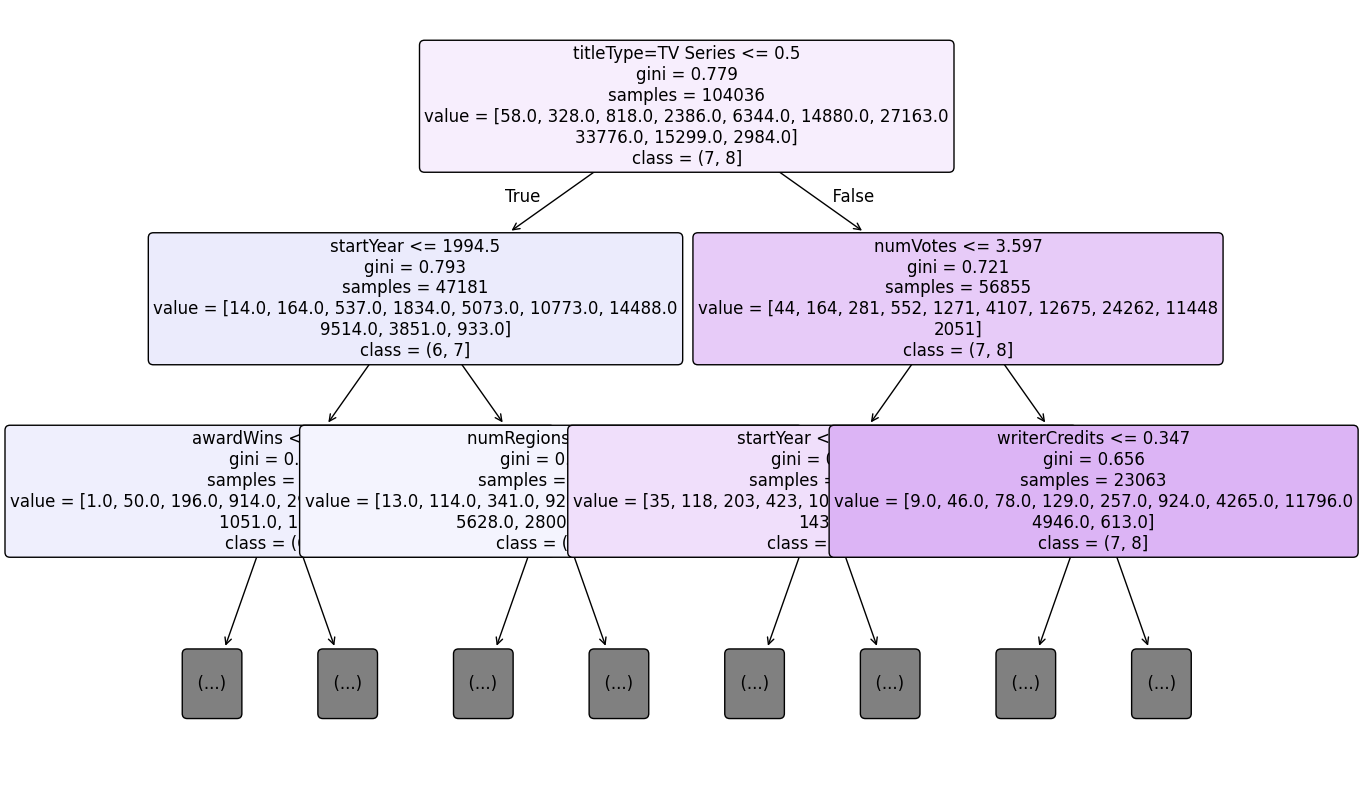

In [ ]:
plt.figure(figsize=(14, 10))
plot_tree(explainer, 
          feature_names=feature_names,
          class_names=list(class_name_map.keys()), 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

In [16]:
y_pred_explainer = explainer.predict(X_test)
y_pred_bb = bb.predict(X_test)

accuracy_score(y_pred_bb, y_pred_explainer) # fidelity

0.5891495469633086

In [17]:
accuracy_score(y_test, y_pred_explainer)

0.3817394814748363

In [18]:
#codice per stampare i primi 10 (numero a piacere) record con la probabilità più alta

# Ottieni le probabilità e le predizioni
probs = bb.predict_proba(X_test)
preds = bb.predict(X_test)

# Crea DataFrame delle probabilità
probs_df = pd.DataFrame(probs, columns=bb.classes_)

# Calcola la probabilità associata alla classe predetta
prob_pred_class = [
    prob[list(bb.classes_).index(pred)]
    for prob, pred in zip(probs, preds)
]

# Crea il DataFrame con le info
results = probs_df.copy()
results["Classe_predetta"] = preds
results["Probabilità_predetta"] = prob_pred_class

# Ordina per probabilità decrescente e prendi i primi 10
top_10 = results.sort_values(by="Probabilità_predetta", ascending=False).head(10)

# Stampa i top 10
print("I 10 record con la predizione più sicura:")
print(top_10)


I 10 record con la predizione più sicura:
         0    1    2    3    4    5    6    7    8    9  Classe_predetta  \
9487   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
15991  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
9064   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0                7   
22446  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
29262  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
9749   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
8979   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
18602  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
13137  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0                9   
29014  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0                5   

       Probabilità_predetta  
9487                    1.0  
15991                   1.0  
9064                    1.0  
2

In [19]:
# Ottieni predizioni e probabilità
probs = bb.predict_proba(X_test)
preds = bb.predict(X_test)

# Crea DataFrame delle probabilità
probs_df = pd.DataFrame(probs, columns=bb.classes_)

# Calcola la probabilità associata alla classe predetta
prob_pred_class = [
    prob[list(bb.classes_).index(pred)]
    for prob, pred in zip(probs, preds)
]

# Etichette vere (true labels)
# Assumo che le etichette vere siano contenute in y_test
# Se usi un'altra variabile, cambia qui
true_labels = np.array(y_test)

# Costruisci il DataFrame dei risultati
results = probs_df.copy()
results["Classe_predetta"] = preds
results["Classe_reale"] = true_labels
results["Probabilità_predetta"] = prob_pred_class

# Filtra solo gli errori
errori = results[results["Classe_predetta"] != results["Classe_reale"]]

# Ordina gli errori per la sicurezza della predizione (in modo decrescente)
errori_top10 = errori.sort_values(by="Probabilità_predetta", ascending=False).head(10)

# Stampa i 10 errori più "sicuri"
print("I 10 errori più sicuri (alta confidenza ma sbagliati):")
print(errori_top10)

I 10 errori più sicuri (alta confidenza ma sbagliati):
         0    1    2         3    4         5         6         7         8  \
21979  0.0  0.0  0.0  0.000000  0.0  0.000000  1.000000  0.000000  0.000000   
14380  0.0  0.0  0.0  0.000000  0.0  0.000000  1.000000  0.000000  0.000000   
39765  0.0  0.0  0.0  0.000000  0.0  0.000000  1.000000  0.000000  0.000000   
2981   0.0  0.0  0.0  0.000000  0.0  0.000000  1.000000  0.000000  0.000000   
23144  0.0  0.0  0.0  0.000000  0.0  0.000000  0.994167  0.005833  0.000000   
6710   0.0  0.0  0.0  0.000000  0.0  0.000000  0.993333  0.006667  0.000000   
9914   0.0  0.0  0.0  0.000000  0.0  0.000000  0.993333  0.003333  0.003333   
36142  0.0  0.0  0.0  0.000000  0.0  0.000000  0.003333  0.990000  0.006667   
9395   0.0  0.0  0.0  0.000833  0.0  0.002778  0.005556  0.987500  0.003333   
27004  0.0  0.0  0.0  0.000000  0.0  0.003333  0.986667  0.003333  0.006667   

         9  Classe_predetta  Classe_reale  Probabilità_predetta  
21979  0.

## Local

In [ ]:
# RECORD A CASO CHE SPIEGA LIME LOCALMENTE (E ALTRI MODELLI LOCALI?)

i2e = 22
x = X_test[i2e]
x

array([1980, 60.0, 0.0, 4.158883083359672, 1.3862943611198906, 0.0, 57,
       0.0, 0.0, 0, 0, 1, 1.3862943611198906, 2.9444389791664403,
       1.791759469228055, 0.0, 1.3862943611198906, 0.6931471805599453,
       0.0, False, False, True, False, False, False], dtype=object)

In [74]:
record2str(x, feature_names, numeric_columns)

'{ startYear = 1980, runtimeMinutes = 60.0, awardWins = 0.0, numVotes = 4.158883083359672, totalImages = 1.3862943611198906, totalVideos = 0.0, totalCredits = 57, criticReviewsTotal = 0.0, AwNmExWins = 0.0, canHaveEpisodes = 0, isAdult = 0, numRegions = 1, userReviewsTotal = 1.3862943611198906, castNumber = 2.9444389791664403, companiesNumber = 1.791759469228055, externalLinks = 0.0, writerCredits = 1.3862943611198906, directorsCredits = 0.6931471805599453, quotesTotal = 0.0, titleType = TV Series }'

In [75]:
bb_outcome = int(bb_predict(x.reshape(1, -1))[0])
bb_outcome_str = class_values[bb_outcome]

print('bb(x) = { %s }' % bb_outcome_str)
print('')

true_outcome = y_test[i2e]
true_outcome_str = class_values[true_outcome]
print('True class = { %s }' % true_outcome_str)

bb(x) = { (7, 8] }

True class = { (6, 7] }


### LIME

In [24]:
# !pip install lime

In [76]:
from lime.lime_tabular import LimeTabularExplainer

In [77]:
lime_explainer = LimeTabularExplainer(
    X_train,
    feature_names=feature_names,
    class_names=[str(v) for v in class_values], 
    discretize_continuous=False
)

In [78]:
exp = lime_explainer.explain_instance(x, bb_predict_proba, labels=[int(bb_outcome), int(true_outcome)]) #in labels specificare gli indici delle classi che si vogliono spiegare

In [79]:
exp.local_exp

{7: [(np.int64(21), np.float64(0.03554729282759624)),
  (np.int64(19), np.float64(-0.02046424467800322)),
  (np.int64(3), np.float64(0.019533652333460126)),
  (np.int64(11), np.float64(-0.007417695994202989)),
  (np.int64(2), np.float64(0.0050369709172565285)),
  (np.int64(1), np.float64(-0.005026405779780429)),
  (np.int64(7), np.float64(-0.004729032705916423)),
  (np.int64(20), np.float64(-0.004305809945836765)),
  (np.int64(12), np.float64(-0.0030803676802050864)),
  (np.int64(14), np.float64(0.0028801565492390076))],
 6: [(np.int64(0), np.float64(-0.0167264302319434)),
  (np.int64(21), np.float64(-0.012231879856090838)),
  (np.int64(11), np.float64(0.008175858079010275)),
  (np.int64(19), np.float64(0.006765828512497818)),
  (np.int64(3), np.float64(-0.006726429391602865)),
  (np.int64(8), np.float64(0.005144378491267803)),
  (np.int64(7), np.float64(0.0045208854867198525)),
  (np.int64(13), np.float64(-0.003772546456215855)),
  (np.int64(14), np.float64(0.003261711719900197)),
  (

In [80]:
print("Classi spiegate da LIME:", exp.local_exp.keys()) #stampa lista degli indici delle classi spiegate

Classi spiegate da LIME: dict_keys([7, 6])



🔍 Spiegazione per la classe PREDETTA:


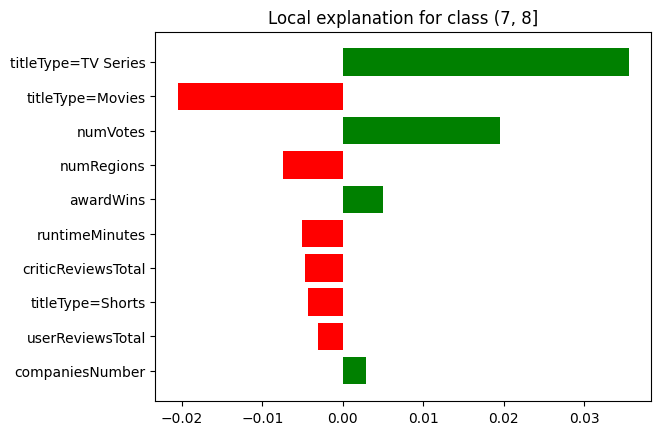

In [81]:
print("\n🔍 Spiegazione per la classe PREDETTA:")
fig1 = exp.as_pyplot_figure(label=bb_outcome)
plt.show()


🔍 Spiegazione per la classe REALE:


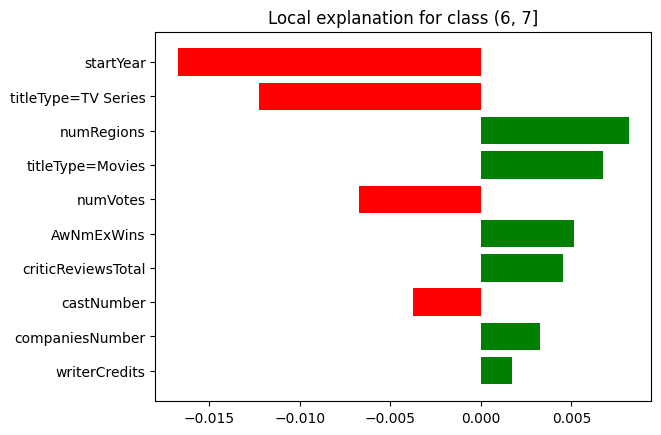

In [82]:
print("\n🔍 Spiegazione per la classe REALE:")
fig1 = exp.as_pyplot_figure(label=true_outcome)
plt.show()

In [83]:
html = exp.as_html()
with open("lime_explanation.html", "w", encoding="utf-8") as f:
    f.write(html)

# Da inserire parte tommy

### SHAP

### SPIEGAZIONE ISTANZA CLASSIFICATA MALE

In [84]:
# pip install shap

In [85]:
import shap
shap.initjs()

In [91]:
f = lambda x: bb_predict_proba(x)[:, 7]
med = np.median(X_train, axis=0).reshape((1, X_train.shape[1]))

shap_explainer = shap.KernelExplainer(f, med)

In [92]:
shap_values_single = shap_explainer.shap_values(x, nsamples=1000)

In [93]:
shap_values_single

array([ 0.06012695,  0.01520604,  0.        ,  0.13256415,  0.01062111,
        0.        ,  0.02953258,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.01808532,  0.03301388,  0.04150848,
       -0.01432154, -0.01016633,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [98]:
shap.force_plot(shap_explainer.expected_value, shap_values_single, features=x, feature_names=feature_names)

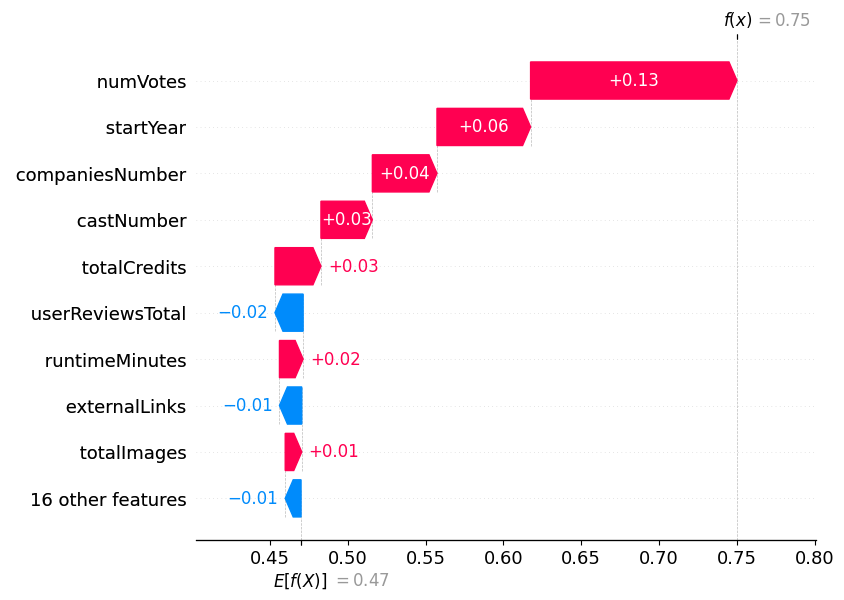

In [95]:
from shap.plots._waterfall import waterfall_legacy

# 1) Determino sv in modo robusto:
if isinstance(shap_values_single, np.ndarray) and shap_values_single.ndim == 2:
    sv = shap_values_single[0]
elif isinstance(shap_values_single, np.ndarray) and shap_values_single.ndim == 1:
    sv = shap_values_single
else:
    raise ValueError(
        f"Mi aspettavo shap_values_single come vettore, ma è {type(shap_values_single)}"
    )

# 2) Assicuro che “features_1d” sia 1-D
#    Se x ha shape (1, M), ravel() restituisce (M,). Se x ha già (M,), rimane (M,).
features_1d = x.ravel()

# 3) Chiamata a waterfall_legacy con sv (array 1-D) e features_1d (array 1-D)
waterfall_legacy(
    shap_explainer.expected_value,  # baseline (float)
    sv,                              # vettore di lunghezza M
    features_1d,                     # valori reali delle feature, 1-D
    feature_names                    # lista di M nomi
)


### SPIEGAZIONE ISTANZA CLASSIFICATA BENE

In [ ]:
i2eg = 36145 #14380 
x1 = X_test[i2eg]
x1

array([1980, 60.0, 0.0, 4.158883083359672, 1.3862943611198906, 0.0, 57,
       0.0, 0.0, 0, 0, 1, 1.3862943611198906, 2.9444389791664403,
       1.791759469228055, 0.0, 1.3862943611198906, 0.6931471805599453,
       0.0, False, False, True, False, False, False], dtype=object)

In [ ]:
f1 = lambda x1: bb_predict_proba(x1)[:, 7]
med = np.median(X_train, axis=0).reshape((1, X_train.shape[1]))

shap_explainer1 = shap.KernelExplainer(f1, med)

In [ ]:
shap_values_single1 = shap_explainer1.shap_values(x2, nsamples=1000)

In [ ]:
shap_values_single1

array([ 0.06012695,  0.01520604,  0.        ,  0.13256415,  0.01062111,
        0.        ,  0.02953258,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.01808532,  0.03301388,  0.04150848,
       -0.01432154, -0.01016633,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
shap.force_plot(shap_explainer1.expected_value, shap_values_single1, features=x1, feature_names=feature_names)

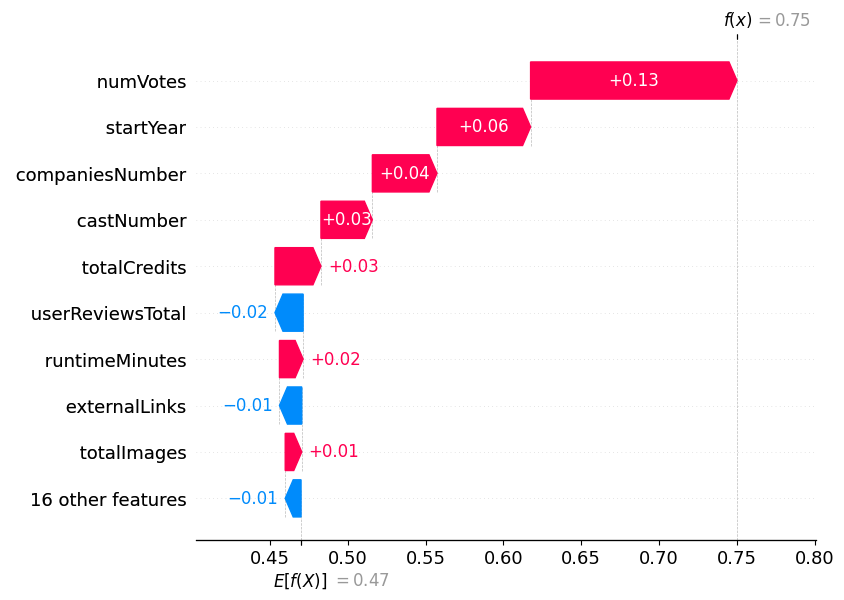

In [ ]:
# 1) Determino sv in modo robusto:
if isinstance(shap_values_single1, np.ndarray) and shap_values_single1.ndim == 2:
    sv = shap_values_single1[0]
elif isinstance(shap_values_single1, np.ndarray) and shap_values_single1.ndim == 1:
    sv = shap_values_single1
else:
    raise ValueError(
        f"Mi aspettavo shap_values_single come vettore, ma è {type(shap_values_single1)}"
    )

# 2) Assicuro che “features_1d” sia 1-D
#    Se x ha shape (1, M), ravel() restituisce (M,). Se x ha già (M,), rimane (M,).
features_1d = x1.ravel()

# 3) Chiamata a waterfall_legacy con sv (array 1-D) e features_1d (array 1-D)
waterfall_legacy(
    shap_explainer1.expected_value,  # baseline (float)
    sv,                              # vettore di lunghezza M
    features_1d,                     # valori reali delle feature, 1-D
    feature_names                    # lista di M nomi
)


### PROVE SU SHAP

In [96]:
# 1. Istanza da spiegare: assicurati che sia un array 2D
x = x.reshape(1, -1)  # se x è 1D (es. da df.iloc[0].values)

# 3. Crea l'explainer per il classificatore tree-based
# explainer = shap.TreeExplainer(bb)

explainer = shap.TreeExplainer(
    bb,
    model_output="raw"  # <-- questo è il termine corretto per log-odds nei tree
)


# 4. Calcola gli shap values per l'istanza
shap_values = explainer.shap_values(x)

# 5. Ottieni la classe predetta
pred_class = bb.predict(x)[0]  # intero, es: 6

# 6. Visualizza il force plot per la classe predetta
shap.force_plot(
    explainer.expected_value[pred_class],         # valore base per la classe predetta
    shap_values[0, :, pred_class],                # valori SHAP: [instance, feature, class]
    features=x[0],                                # input originale
    feature_names=feature_names                   # nomi delle feature
)

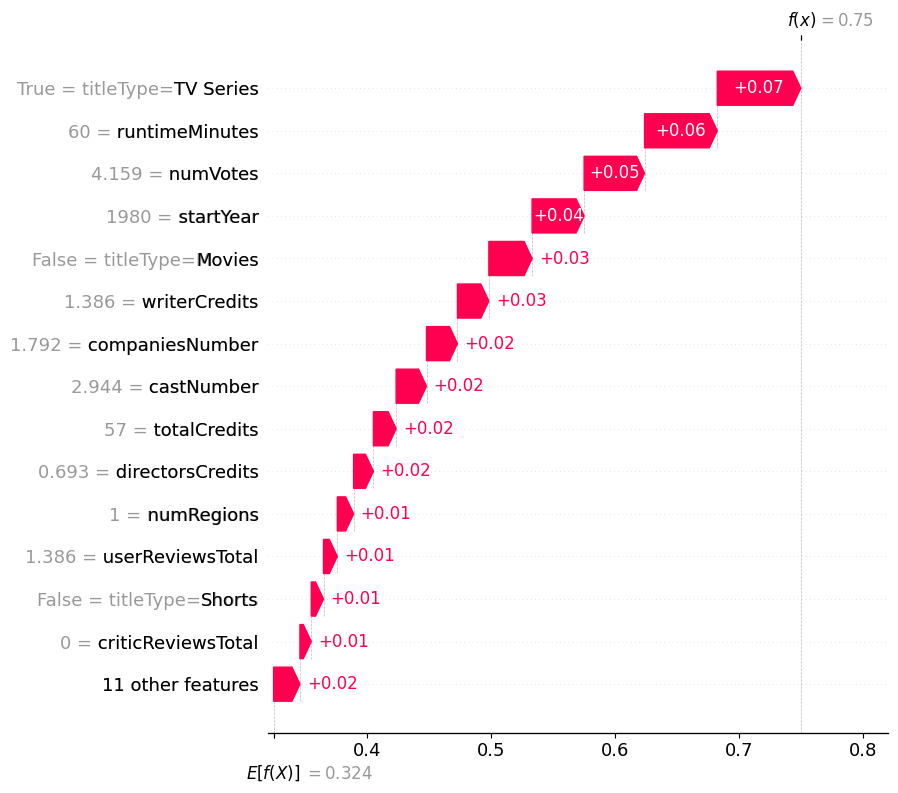

In [97]:
# 4. Crea un oggetto Explanation per la classe predetta
exp = shap.Explanation(
    values=shap_values[0, :, pred_class],
    base_values=explainer.expected_value[pred_class],
    data=x[0],
    feature_names=feature_names
)

# 5. Visualizza il waterfall plot
shap.plots.waterfall(exp, max_display=15)

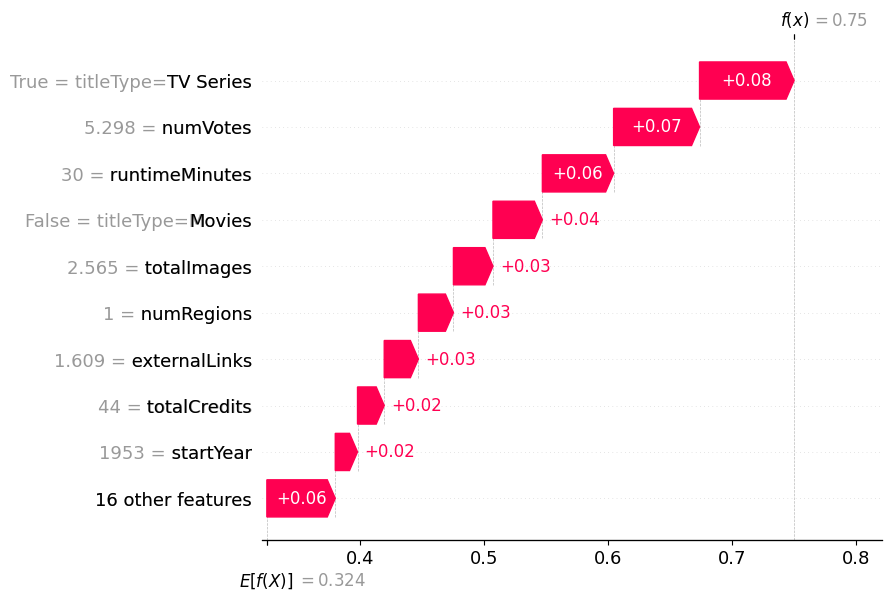

In [41]:
# Predizione della classe
pred_class = bb.predict(x)[0]
class_index = list(bb.classes_).index(pred_class)

# Estrai gli shap values corretti (per la prima istanza, per la classe predetta)
shap_values_instance = shap_values[0, :, class_index]

# Costruisci l'oggetto Explanation (per il grafico waterfall in log-odds)
explanation = shap.Explanation(
    values=shap_values_instance,
    base_values=explainer.expected_value[class_index],
    data=x[0],
    feature_names=feature_names
)

# Mostra il grafico
shap.plots.waterfall(explanation)


### FINE PROVE SU SHAP

### LORE

In [ ]:
# MI SONO FERMATO ALL IMPORTAZIONE DI LOREM
from lorem import LOREM

ModuleNotFoundError: No module named 'lorem'

In [ ]:
_, K, _, _ = train_test_split(
    rdf[real_feature_names].values, 
    rdf[class_name].values, 
    test_size=test_size,
    random_state=random_state, 
    stratify=df[class_name].values
)

NameError: name 'train_test_split' is not defined

In [ ]:
lore_explainer = LOREM(K, bb_predict, feature_names, class_name, class_values, numeric_columns, features_map,
                       neigh_type='geneticp', categorical_use_prob=True, continuous_fun_estimation=False, 
                       size=1000, ocr=0.1, random_state=42, ngen=10, bb_predict_proba=bb_predict_proba, 
                       verbose=True)

calculating feature values


In [ ]:
exp = lore_explainer.explain_instance(x, samples=300, use_weights=True, metric=neuclidean)

generating neighborhood - geneticp
gen	nevals	avg     	min     	max     
0  	150   	0.496654	0.496654	0.496654
1  	131   	0.696323	0.496654	0.993207
2  	134   	0.852242	0.496654	0.993214
3  	126   	0.911261	0.552249	0.993214
4  	131   	0.920091	0.531453	0.993214
5  	127   	0.938976	0.551935	0.993214
6  	124   	0.933553	0.531633	0.993264
7  	125   	0.935763	0.531653	0.99324 
8  	137   	0.925204	0.551668	0.99327 
9  	124   	0.935196	0.531499	0.99327 
10 	118   	0.947229	0.531538	0.99327 
gen	nevals	avg	min	max
0  	150   	0.5	0.5	0.5
1  	125   	0.584347	0.499254	0.961106
2  	131   	0.725675	0.499719	0.961106
3  	127   	0.846991	0.504654	0.961076
4  	131   	0.894284	0.504858	0.961019
5  	132   	0.908944	0.505002	0.96114 
6  	133   	0.908713	0.537226	0.961131
7  	128   	0.917474	0.504742	0.961141
8  	127   	0.925317	0.509923	0.961187
9  	126   	0.912074	0.519618	0.961101
10 	121   	0.908423	0.519524	0.961121
synthetic neighborhood class counts {False: 244, True: 116}
learning local decision

In [ ]:
print(exp)

r = { total day minutes > 247.46, total day charge > 38.10, total eve minutes > 172.14, total night charge > 4.61, account length > 47.50, total intl minutes > 9.29 } --> { churn: True }
c = { { total eve minutes <= 172.14 } }


In [ ]:
x1 = x.copy()
x1[feature_names.index('total eve minutes')] = 170

print('x1 = %s' % record2str(x1, feature_names, numeric_columns))
print('')

x1 = { account length = 49, area code = 415, number vmail messages = 0, total day minutes = 266.3, total day calls = 90, total day charge = 45.27, total eve minutes = 170, total eve calls = 117, total eve charge = 17.66, total night minutes = 205.0, total night calls = 98, total night charge = 9.23, total intl minutes = 14.0, total intl calls = 2, total intl charge = 3.78, customer service calls = 2, state = UT, international plan = no, voice mail plan = no }



In [ ]:
bb_outcome = bb_predict(x1.reshape(1, -1))[0]
bb_outcome_str = class_values[bb_outcome]

print('bb(x) = { %s }' % bb_outcome_str)
print('')

bb(x) = { False }



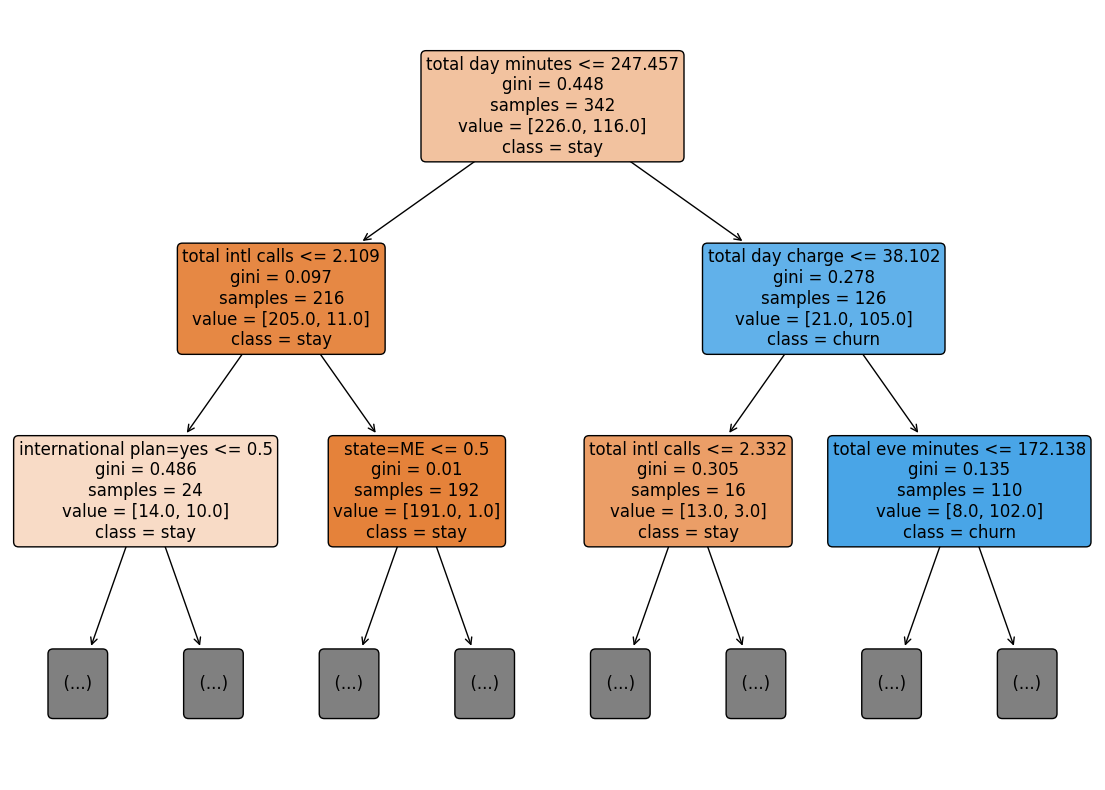

In [ ]:
plt.figure(figsize=(14, 10))
plot_tree(exp.dt, 
          feature_names=feature_names, 
          class_names=['stay', 'churn'], 
          filled=True, 
          rounded=True,
          fontsize=12,
          max_depth=2)  
plt.show()

### Counterfactual Explanations

In [ ]:
# !pip install fat-forensics

In [ ]:
import fatf.transparency.predictions.counterfactuals as fatf_cf

24-May-17 16:12:02 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [ ]:
# Create a Counterfactual Explainer
cf_explainer = fatf_cf.CounterfactualExplainer(
    model=bb,
    dataset=X_test.astype(float), # cast booleans to float, library dataset has to be of a base type (strings and/or numbers).
    categorical_indices=[],
    default_numerical_step_size=1,
    max_counterfactual_length=1
)

In [ ]:
dp_1_cf_tuple = cf_explainer.explain_instance(x1.astype(float))
dp_1_cfs, dp_1_cfs_distances, dp_1_cfs_predictions = dp_1_cf_tuple

In [ ]:
dp_1_cfs

array([[ 49.  , 415.  ,   0.  , 266.3 ,  90.  ,  45.27, 170.  , 117.  ,
         17.66, 205.  ,  98.  ,   9.23,  14.  ,   2.  ,   3.78,   2.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ],
       [ 49.  , 415.  ,   0.  , 266.3 ,  90.  ,  45.27, 170.  , 117.  ,
         17.66, 205.  ,  98.  ,   9.23,  14.  ,   2.  ,   3.78,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,

In [ ]:
dp_1_cfs_text = fatf_cf.textualise_counterfactuals(
    x1.astype(float),
    dp_1_cfs,
    instance_class=bb_outcome,
    counterfactuals_distances=dp_1_cfs_distances,
    counterfactuals_predictions=dp_1_cfs_predictions)
print(dp_1_cfs_text)

Instance (of class *0*):
[ 49.   415.     0.   266.3   90.    45.27 170.   117.    17.66 205.
  98.     9.23  14.     2.     3.78   2.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
   1.     0.     0.     0.     0.     0.     0.     1.     0.     1.
   0.  ]

Feature names: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]

Counterfactual instance (of class *1*):
Distance: 1.0
    feature *67*: *1.0* -> *0.0*

Counterfactual instance (of class *1*):
Distance: 2.0
    feature *15*: *2.0* -> *0.0*

Counterfactual 

### DALEX

- https://dalex.drwhy.ai/python-dalex-titanic.html
- https://github.com/ModelOriented/DALEX